In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'marmoset'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'marmoset.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,call_num,pulse_num,indv,indvi,key,audio,rate,spectrogram
0,5.000000,6.688911,phee,5,0,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[-0.0028140772962798664, -0.002767839704774081...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,7.008134,7.757936,phee,5,1,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[-0.0017946614847837742, -0.004523495411240861...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,28.414626,29.981045,phee,6,0,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[0.001508825282652068, 0.001441084705503678, 0...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### subset out multiple phees

In [9]:
syllable_df = syllable_df[
    ((syllable_df.end_time - syllable_df.start_time).values < 2)
    & ((syllable_df.end_time - syllable_df.start_time).values > 0.75)
]

In [10]:
syllable_df = syllable_df[np.array([np.sum(i) for i in syllable_df.spectrogram.values]) > 100]

In [11]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,leo,todd,ares,aladdin,ben,apollo,baloo,han,jasmine,angel,...,nasira,copper,louie,waylon,mango,chewie,kiwi,william,rafiki,luna
0,293,784,706,58,232,193,40,473,121,261,...,1,1042,8,819,22,47,4,16,2,1


### subset dataframe
- there is some noise in labelling we want to remove

In [12]:
indv_to_plot = [i for i in syllable_df.indv.unique() if np.sum(syllable_df.indv == i) > 500]
indv_to_plot

['todd', 'ares', 'hank', 'hermes', 'copper', 'waylon']

In [13]:
subset_df = syllable_df[
    syllable_df.indv.isin(indv_to_plot) & 
    np.array([np.sum(i) > 100 for i in syllable_df.spectrogram.values])
]

In [14]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [15]:
specs = subset_df.spectrogram.values
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)

In [16]:
subset_df[:3]

,start_time,end_time,labels,call_num,pulse_num,indv,indvi,key,audio,rate,spectrogram
0,4.709327,6.209533,phee,0,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[-0.03685876581967961, 0.09483572331057642, 0....",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
26,321.779270,323.701189,phee,23,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[0.43788622626306195, 0.1657618508572237, -0.3...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,17.037117,17.936183,phee,0,0,ares,1,ares.todd.171030__h-1m59s55.58134565861883,"[-0.06814119890784297, -0.06236998927817981, -...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [17]:
def norm(x):
    x[x<0] = 0
    return x
subset_df['spectrogram'] = [norm(i) for i in subset_df.spectrogram.values]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### cluster and plot

In [18]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [19]:
cuml_umap = cumlUMAP(min_dist=0.25)
embedding = cuml_umap.fit_transform(specs_flattened)

In [20]:
z  = list(embedding)

In [21]:
z = np.vstack(z)

In [22]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [23]:
specs = [i - np.min(i) for i in tqdm(specs)]

In [24]:
np.max(specs)

1.0

In [25]:
ensure_dir(FIGURE_DIR / 'discrete_umap' / 'indv')

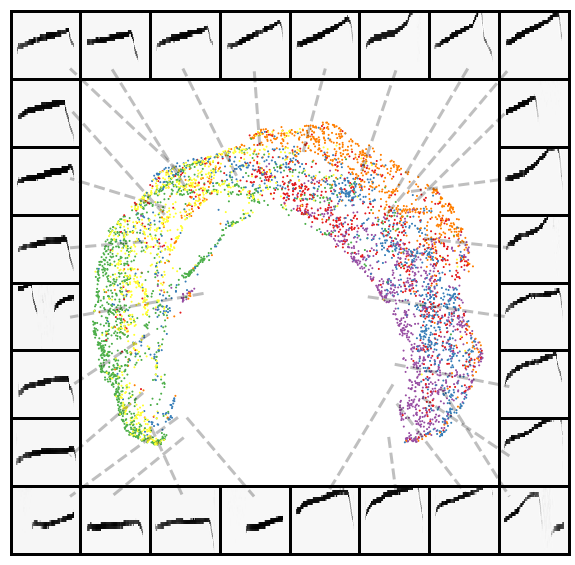

In [26]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'indv' / 'marmoset', dpi=300, save_jpg=True, save_png=True)

### get silhouette score

In [30]:
from scipy.stats import kruskal

In [31]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [32]:
samples = silhouette_samples(list(z), labels = subset_df.indv.values)
chance_samples = silhouette_samples(list(z), labels = np.random.permutation(subset_df.indv.values))

In [33]:
kruskal(samples, chance_samples)

KruskalResult(statistic=22.747634149869555, pvalue=1.8473142687114187e-06)

In [34]:
print(np.mean(samples))

-0.06296394879835426


### Save for paper

In [39]:
subset_df[:3]

,start_time,end_time,labels,call_num,pulse_num,indv,indvi,key,audio,rate,spectrogram,umap_spectrogram,silhouette
0,4.709327,6.209533,phee,0,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[-0.03685876581967961, 0.09483572331057642, 0....",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[8.270054817199707, -4.905511379241943]",-0.536137
26,321.779270,323.701189,phee,23,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[0.43788622626306195, 0.1657618508572237, -0.3...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-5.332974433898926, 0.8508735299110413]",-0.553058
0,17.037117,17.936183,phee,0,0,ares,1,ares.todd.171030__h-1m59s55.58134565861883,"[-0.06814119890784297, -0.06236998927817981, -...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-7.7373175621032715, -1.6621456146240234]",-0.615720


In [36]:
subset_df['umap_spectrogram'] = list(z)
subset_df['silhouette'] = list(samples)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
ensure_dir(DATA_DIR / "paper_data" / "indv_id" / 'marmoset')
subset_df.to_pickle(DATA_DIR / "paper_data" / "indv_id" / 'marmoset' / "marmoset.pickle")